In [133]:
import os
import pandas as pd
from wildlife_datasets import datasets, metrics
from wildlife_datasets.analysis import display_statistics
from wildlife_datasets import splits
from wildlife_tools.data import ImageDataset
import torchvision.transforms as T
import timm
from wildlife_tools.features import DeepFeatures

In [134]:
class Horses(datasets.WildlifeDataset):
    def create_catalogue(self) -> pd.DataFrame:
        dataset_path = "horse_dataset"
        rows = []
        
        # Walk through the dataset directory
        for horse_name in os.listdir(dataset_path):
            horse_dir = os.path.join(dataset_path, horse_name)
            if os.path.isdir(horse_dir):
                # Process each image in the horse's directory
                for image_file in os.listdir(horse_dir):
                    if image_file.lower().endswith(('.jpeg', '.jpg', '.png')):
                        # Extract image_id from filename (remove extension and horse name)
                        image_id = image_file.rsplit('.', 1)[0]  # Remove extension
                        
                        rows.append({
                            'image_id': image_id,
                            'identity': horse_name,
                            'path': os.path.join(horse_dir, image_file)
                        })
        
        # Create DataFrame from collected rows
        df = pd.DataFrame(rows)
        result = self.finalize_catalogue(df)
        return result

In [135]:
horses = Horses('.')
df = horses.create_catalogue()

Number of identitites            10
Number of all animals            68
Number of animals with one image 0
Number of unidentified animals   0


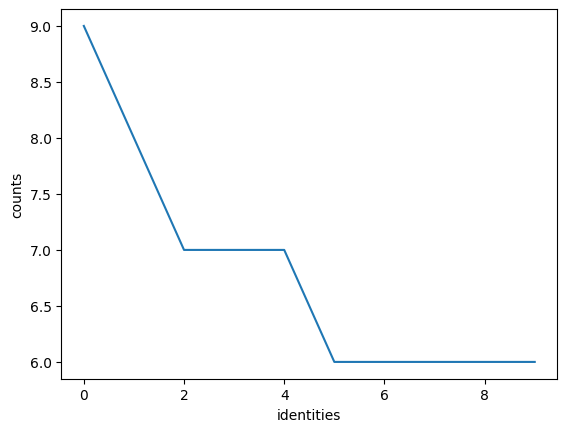

In [136]:
display_statistics(df)

Figure(640x480)


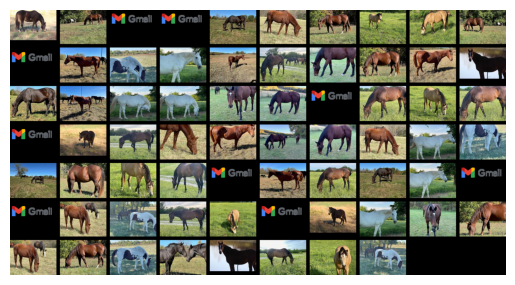

In [137]:
print(horses.plot_grid(n_rows=25, n_cols=10))

split the catalog into training and testing sets

In [138]:
splitter = splits.ClosedSetSplit(0.8)
idx_train, idx_test = splitter.split(horses.df)[0]
df_train = horses.df.loc[idx_train]
df_test = horses.df.loc[idx_test]

In [139]:
df_train

,image_id,identity,path
4,Cadet_4_0,Cadet,horse_dataset/Cadet/Cadet_4_0.jpeg
3,Cadet_3_0,Cadet,horse_dataset/Cadet/Cadet_3_0.jpeg
0,Cadet_0_0,Cadet,horse_dataset/Cadet/Cadet_0_0.jpeg
1,Cadet_1_0,Cadet,horse_dataset/Cadet/Cadet_1_0.jpeg
5,Cadet_5_0,Cadet,horse_dataset/Cadet/Cadet_5_0.jpeg
10,Cowboy_1_2,Cowboy,horse_dataset/Cowboy/Cowboy_1_2.jpeg
6,Cowboy_0_0,Cowboy,horse_dataset/Cowboy/Cowboy_0_0.jpeg
13,Cowboy_2_0,Cowboy,horse_dataset/Cowboy/Cowboy_2_0.jpeg
7,Cowboy_0_1,Cowboy,horse_dataset/Cowboy/Cowboy_0_1.png
9,Cowboy_1_1,Cowboy,horse_dataset/Cowboy/Cowboy_1_1.jpeg


In [140]:
df_test

,image_id,identity,path
2,Cadet_2_0,Cadet,horse_dataset/Cadet/Cadet_2_0.jpeg
8,Cowboy_1_0,Cowboy,horse_dataset/Cowboy/Cowboy_1_0.jpeg
12,Cowboy_1_4,Cowboy,horse_dataset/Cowboy/Cowboy_1_4.jpeg
15,Dora_0_1,Dora,horse_dataset/Dora/Dora_0_1.jpeg
21,Ernie_0_1,Ernie,horse_dataset/Ernie/Ernie_0_1.jpeg
31,Jake_1_3,Jake,horse_dataset/Jake/Jake_1_3.jpeg
33,Martien_0_0,Martien,horse_dataset/Martien/Martien_0_0.png
41,Moose_0_1,Moose,horse_dataset/Moose/Moose_0_1.jpeg
51,Pistol_1_2,Pistol,horse_dataset/Pistol/Pistol_1_2.jpeg
53,Pluto_0_1,Pluto,horse_dataset/Pluto/Pluto_0_1.png


create ImageDataset for the test and train catalogs

In [141]:
model = 'hf-hub:BVRA/MegaDescriptor-T-224'
#model = 'hf-hub:BVRA/MegaDescriptor-L-384'

image_size= 224
#image_size = 384

In [142]:
transform = T.Compose([T.Resize([image_size, image_size]), T.ToTensor(), T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
dataset_test = ImageDataset(df_test, horses.root, transform=transform)
dataset_train = ImageDataset(df_train, horses.root, transform=transform)

Extract features using MegaDescriptor

In [143]:
extractor = DeepFeatures(timm.create_model(model, num_classes=0, pretrained=True))

query, database = extractor(dataset_test), extractor(dataset_train)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Calculate cosine similarity between test and train deep features

In [144]:
from wildlife_tools.similarity import CosineSimilarity

similarity_function = CosineSimilarity()
similarity = similarity_function(query, database)

Evaluate

In [145]:
import numpy as np
from wildlife_tools.inference import KnnClassifier

classifier = KnnClassifier(k=1, database_labels=dataset_train.labels_string)
predictions = classifier(similarity)
accuracy = np.mean(dataset_test.labels_string == predictions)

In [146]:
predictions

array(['Cadet', 'Cowboy', 'Cowboy', 'Dora', 'Ernie', 'Jake', 'Moose',
       'Moose', 'Pistol', 'Moose', 'Moose', 'Pluto'], dtype='<U6')

In [147]:
dataset_test.labels_string

array(['Cadet', 'Cowboy', 'Cowboy', 'Dora', 'Ernie', 'Jake', 'Martien',
       'Moose', 'Pistol', 'Pluto', 'Toga', 'Toga'], dtype=object)

In [148]:
accuracy

np.float64(0.6666666666666666)